## CHAPTER 8: 어텐션

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

#### 8.1.1 seq2seq의 문제점

+ Encoder의 출력이 고정 길이의 벡터

#### 8.1.2 Encoder 개선

Encoder의 출력의 길이는 입력 문장의 길이에 따라 바꿔주는게 좋습니다.

구체적으로, 시각별 LSTM 계층의 은닉 상태 벡터를 모두 이용하는 것입니다.

<img src=attachment:image.png width=400px></img>
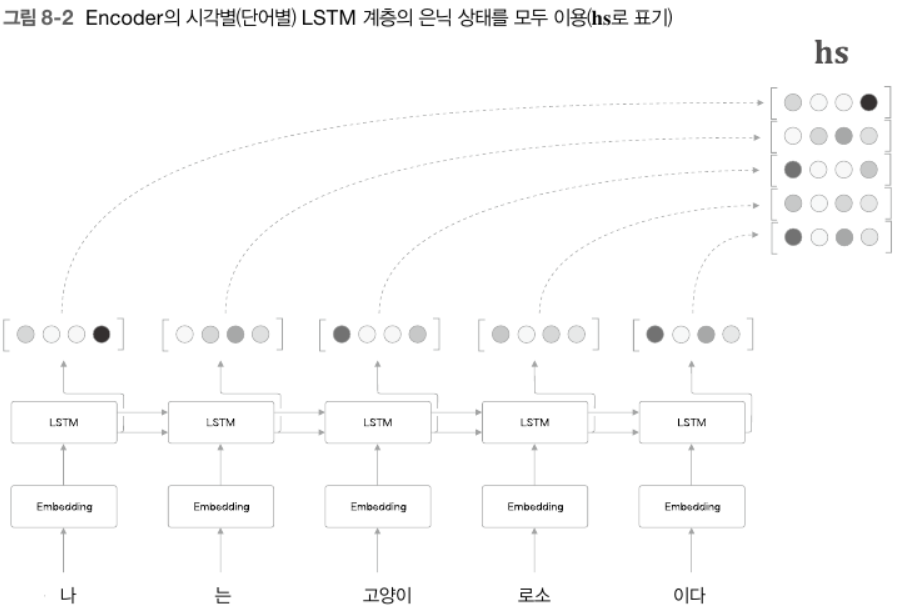

#### 8.1.3 Decoder 개선 ①

'도착어 단어'와 대응 관계에 있는 '출발어 단어'의 정보를 골라냅니다.

<img src=attachment:image.png width=500px></img><br>

각 단어의 중요도를 나타내는 가중치 a와 각 단어의 벡터 hs로부터 가중합<sup>weighted sum</sup>을 구하여, 맥락 벡터 c를 얻습니다.

<img src=attachment:image-2.png width=500px></img>
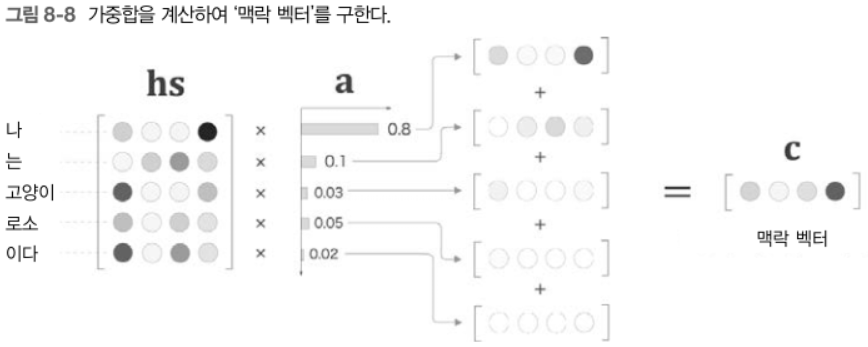
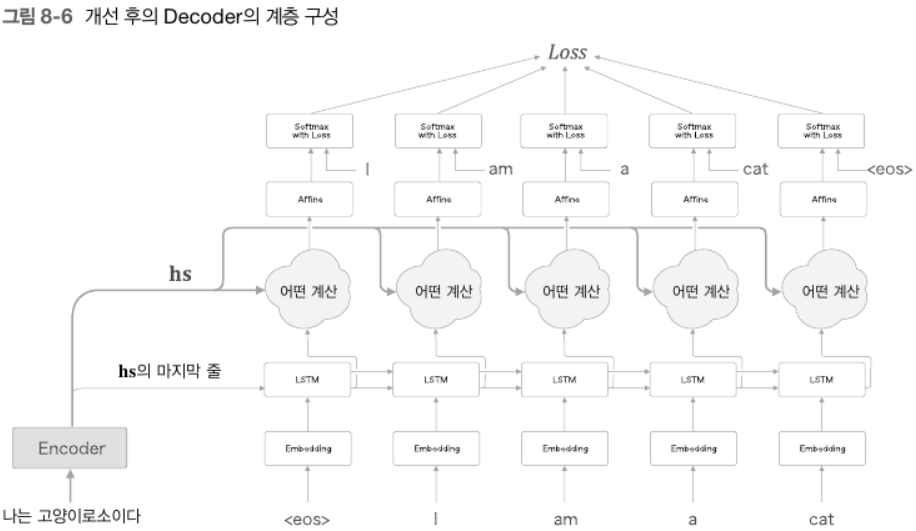

가중합 계산을 계산 그래프로 그려보면 다음과 같습니다.

<img src=attachment:image.png width=200px></img>
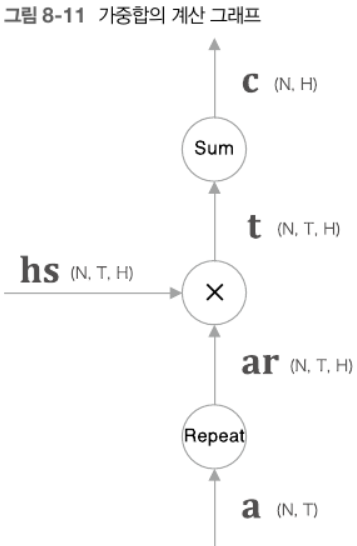

In [ ]:
class WeightSum:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
    
    def forward(self, hs, a):
        N, T, H = hs.shape
        
        ar = a.reshape(N,T,1).repeat(H, axis=2)
        t = hs * ar
        c = np.sum(t, axis=1)
        
        self.cache = (hs, ar)
        return c
        
    def backward(self, dc):
        hs, ar = self.cache
        N, T, H = hs.shape
        
        dt = dc.reshape(N,1,H).repeat(T, axis=1) # sum의 역전파
        dar = dt * hs
        dhs = dt * ar
        da = np.sum(dar, axis=2) # repeat의 역전파
        
        return dhs, da

#### 8.1.4 Decoder 개선 ②

각 단어의 중요도를 나타내는 가중치 a를 어떻게 구해야 할까요?

Decoder의 LSTM 계층의 은닉 상태 벡터 h가 Encoder의 hs의 각 단어 벡터와 얼마나 '비슷한가'를 수치화합니다.

<img src=attachment:image-2.png width=350px></img>

이후 위에서 획득한 s를 정규화하기 위해 소프트맥스 함수를 적용하면 a를 얻을 수 있습니다.
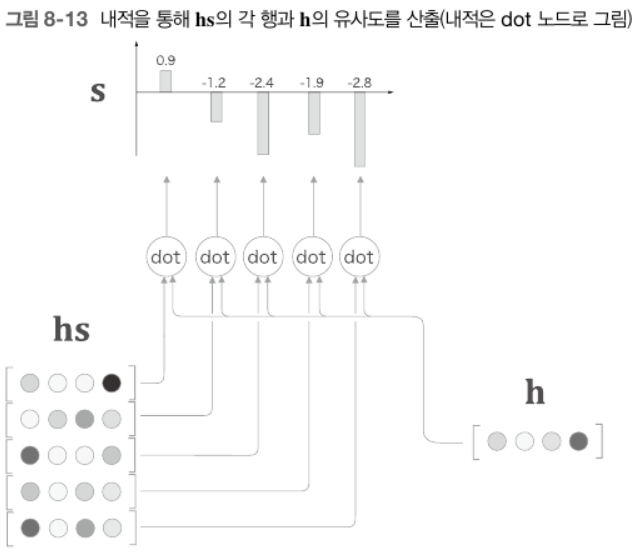

이 과정을 계산 그래프로 그려보면 다음과 같습니다.

<img src=attachment:image.png width=200px></img>
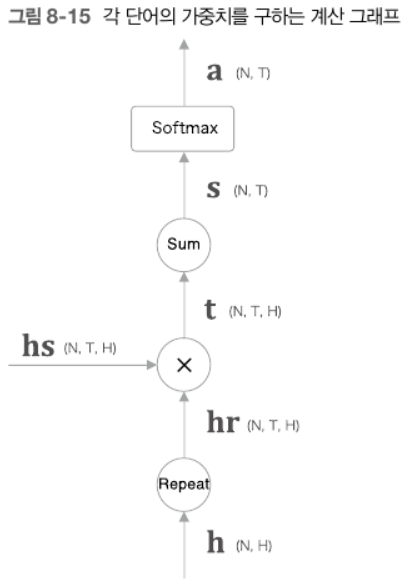

In [ ]:
import sys; sys.path.append('exam_code')
from common.np import *
from common.layers import Softmax

class AttentionWeight:
    def __init__(self):
        self.params, self.grads = [], []
        self.softmax = Softmax()
        self.cache = None
        
    def forward(self, hs, h):
        N, T, H = hs.shape
        
        hr = h.reshape(N, 1, H).repeat(T, axis=1)
        t = hs * hr
        s = np.sum(t, axis=2)
        a = self.softmax.forward(s)
        
        self.cache = (hs, hr)
        return a
    
    def backward(self, da):
        hs, hr = self.cache
        N, T, H = hs.shape
        
        ds = self.softmax.backward(da)
        dt = ds.reshape(N, T, 1).repeat(H, axis=2)
        dhs = dt * hr
        dhr = dt * hs
        dh = sum(dhr, axis=1)
        
        return dhs, dh

#### 8.1.5 Decoder 개선 ③

8.1.3절에서 구현한 **Weight Sum** 계층과 8.1.4절에서 구현한 **Attention Weight** 계층을 하나로 결합합니다.

<img src=attachment:image-2.png width=400px></img>
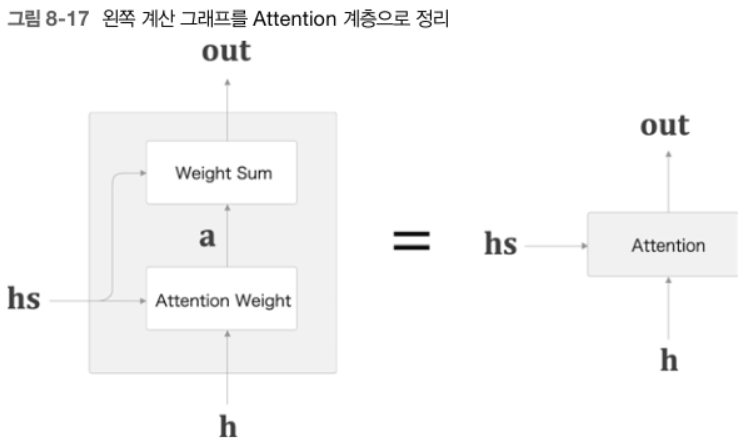

In [ ]:
class Attention:
    def __init__(self):
        self.params, self.grads = [], []
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer       = WeightSum()
        self.attention_weight = None
        
    def forward(self, hs, h):
        a = self.attention_weight_layer.forward(hs, h)
        out = self.weight_sum_layer.forward(hs, a)
        self.attention_weight = a
        return out
    
    def backward(self, dout):
        dhs0, da = self.weight_sum_layer.backward(dout)
        dhs1, dh = self.attention_weight_layer.backward(da)
        dhs = dhs0 + dhs1
        return dhs, dh

<img src=attachment:image.png width=600px></img>
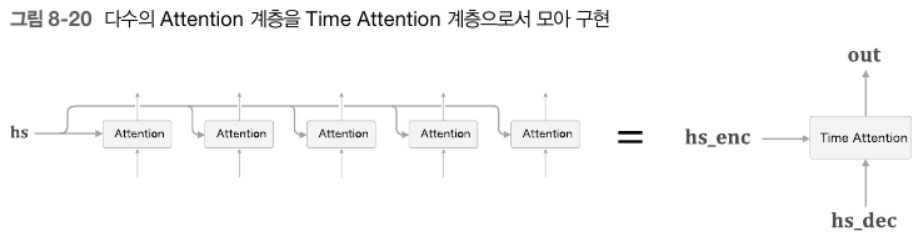

In [ ]:
class TimeAttention:
    def __init__(self):
        self.params, self.grads = [], []
        self.layers = None
        self.attention_weights = None
    
    def forward(self, hs_enc, hs_dec):
        N, T, H = hs_dec.shape
        out = np.empty_like(hs_dec)
        self.layers = []
        self.attention_weights = []
        
        for t in range(T):
            layer = Attention()
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:, t, :])
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weight)
        
        return out
        
    def backward(self, dout):
        N, T, H = dout.shape
        dhs_enc = 0
        dhs_dec = np.empty_like(hs_dec)
        
        for t in range(T):
            layer = self.layers[t]
            dhs, dh = layer.backward(dout[:, t, :])
            dhs_enc += dhs
            dhs_dec[:, t, :] = dh
            
        return dhs_enc, dhs_dec

### 8.2 어텐션을 갖춘 seq2seq 구현

#### 8.2.1 Encoder 구현

In [ ]:
import sys; sys.path.append('exam_code')
from common.time_layers import *
from ch07.seq2seq import Encoder, Seq2seq
from ch08.attention_layer import TimeAttention

class AttentionEncoder(Encoder):
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        return hs
        
    def backward(self, dhs):
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

#### 8.2.2 Decoder 구현

<img src=attachment:image.png width=400px></img>
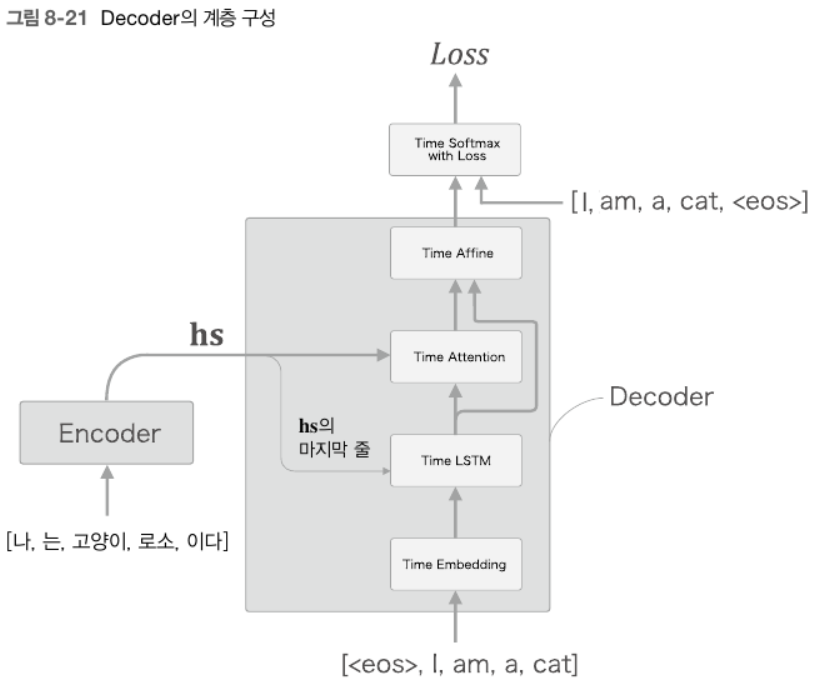

In [ ]:
class AttentionDecoder(Decoder):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
    
        embed_W = (rn(V,D)/100).astype('f')
        lstm_Wx = (rn(D,4*H)/np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H,4*H)/np.sqrt(H)).astype('f')
        lstm_b  = np.zeros(4*H).astype('f')
        affine_W = (rn(H,V)/np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        self.embed     = TimeEmbedding(embed_W)
        self.lstm      = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)
        self.attention = TimeAttention()
        self.affine    = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]
        
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads  += layer.grads
    
    def forward(self, xs, enc_hs):
        h = enc_hs[:, -1]
        self.lstm.set_state(h)
        
        out    = self.embed.forward(xs)
        dec_hs = self.lstm.forward(out)
        c      = self.attention.forward(enc_hs, dec_hs)
        out    = np.concatenate((c, dec_hs), axis=2)
        score = self.affine.forward(out)
        return score
        
    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dc, ddec_hs0 = dout[]
        denc_hs, ddec_hs1 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1
        dout = self.lstm.backward(ddec_hs)
        dh = self.lstm.dh
        denc_hs[:, -1] += dh
        dout = self.embed.backward(dout)
        return denc_hs
    
    def generate(self, enc_hs, start_id, sample_size):
        sampled = []
        sample_id = start_id
        h = enc_hs[:, -1]
        self.lstm.set_state(h)
        
        for _ in range(sample_size):
            x      = np.array(sample_id).reshape(1,1)
            out    = self.embed.forward(x)
            dec_hs = self.lstm.forward(out)
            c      = self.attention.forward(enc_hs, dec_hs)
            out    = np.concatenate((c, dec_hs), axis=2)
            score  = self.affine.forward(out)
            
            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))
        
        return sampled

#### 8.2.3 seq2seq 구현

In [ ]:
class AttentionSeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args)
        self.decoder = AttentionDecoder(*args)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads  = self.encoder.grads + self.decoder.grads

### 8.3 어텐션 평가

"날짜 형식"을 변경하는 문제로 어텐션을 갖춘 seq2seq의 효과를 확인해보겠습니다.

<img src=attachment:image.png width=300px></img>
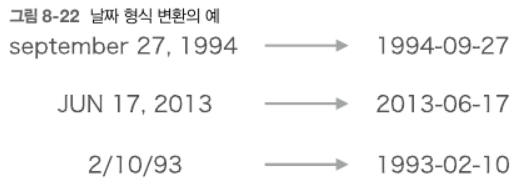

#### 8.3.2 어텐션을 갖춘 seq2seq의 학습

In [5]:
import sys; sys.path.append('exam_code'); sys.path.append('exam_code/ch07')
import numpy as np
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from ch08.attention_seq2seq import AttentionSeq2seq
from ch07.seq2seq import Seq2seq
from ch07.peeky_seq2seq import PeekySeq2seq

# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 입력 문장 반전
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# 하이퍼파라미터 설정
vocab_size   = len(char_to_id)
wordvec_size = 16
hidden_size  = 256
batch_size   = 128
max_epoch    = 10
max_grad     = 5.0

# 모델 / 옵티마이저 / 트레이너 생성
model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1, 
                batch_size=batch_size, max_grad=max_grad)
    
    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                   id_to_char, verbose, is_reverse=True)
        
    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc*100))

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 4.08
| 에폭 1 |  반복 21 / 351 | 시간 7[s] | 손실 3.09
| 에폭 1 |  반복 41 / 351 | 시간 14[s] | 손실 1.90
| 에폭 1 |  반복 61 / 351 | 시간 22[s] | 손실 1.72
| 에폭 1 |  반복 81 / 351 | 시간 30[s] | 손실 1.46
| 에폭 1 |  반복 101 / 351 | 시간 37[s] | 손실 1.19
| 에폭 1 |  반복 121 / 351 | 시간 45[s] | 손실 1.14
| 에폭 1 |  반복 141 / 351 | 시간 52[s] | 손실 1.09
| 에폭 1 |  반복 161 / 351 | 시간 60[s] | 손실 1.06
| 에폭 1 |  반복 181 / 351 | 시간 67[s] | 손실 1.04
| 에폭 1 |  반복 201 / 351 | 시간 75[s] | 손실 1.03
| 에폭 1 |  반복 221 / 351 | 시간 82[s] | 손실 1.02
| 에폭 1 |  반복 241 / 351 | 시간 90[s] | 손실 1.02
| 에폭 1 |  반복 261 / 351 | 시간 97[s] | 손실 1.01
| 에폭 1 |  반복 281 / 351 | 시간 105[s] | 손실 1.00
| 에폭 1 |  반복 301 / 351 | 시간 112[s] | 손실 1.00
| 에폭 1 |  반복 321 / 351 | 시간 119[s] | 손실 1.00
| 에폭 1 |  반복 341 / 351 | 시간 127[s] | 손실 1.00
Q 10/15/94                     
T 1994-10-15
X 1978-08-11
---
Q thursday, november 13, 2008  
T 2008-11-13
X 1978-08-11
---
Q Mar 25, 2003                 
T 2003-03-25
X 1978-08-11
---
Q Tuesday, November 22, 20

검증 정확도 99.960%
| 에폭 7 |  반복 1 / 351 | 시간 0[s] | 손실 0.00
| 에폭 7 |  반복 21 / 351 | 시간 8[s] | 손실 0.00
| 에폭 7 |  반복 41 / 351 | 시간 16[s] | 손실 0.00
| 에폭 7 |  반복 61 / 351 | 시간 23[s] | 손실 0.00
| 에폭 7 |  반복 81 / 351 | 시간 31[s] | 손실 0.00
| 에폭 7 |  반복 101 / 351 | 시간 39[s] | 손실 0.00
| 에폭 7 |  반복 121 / 351 | 시간 47[s] | 손실 0.00
| 에폭 7 |  반복 141 / 351 | 시간 54[s] | 손실 0.00
| 에폭 7 |  반복 161 / 351 | 시간 62[s] | 손실 0.00
| 에폭 7 |  반복 181 / 351 | 시간 70[s] | 손실 0.00
| 에폭 7 |  반복 201 / 351 | 시간 78[s] | 손실 0.00
| 에폭 7 |  반복 221 / 351 | 시간 86[s] | 손실 0.00
| 에폭 7 |  반복 241 / 351 | 시간 94[s] | 손실 0.00
| 에폭 7 |  반복 261 / 351 | 시간 101[s] | 손실 0.00
| 에폭 7 |  반복 281 / 351 | 시간 109[s] | 손실 0.00
| 에폭 7 |  반복 301 / 351 | 시간 117[s] | 손실 0.00
| 에폭 7 |  반복 321 / 351 | 시간 125[s] | 손실 0.00
| 에폭 7 |  반복 341 / 351 | 시간 133[s] | 손실 0.00
Q 10/15/94                     
T 1994-10-15
O 1994-10-15
---
Q thursday, november 13, 2008  
T 2008-11-13
O 2008-11-13
---
Q Mar 25, 2003                 
T 2003-03-25
O 2003-03-25
---
Q Tuesday,

### 8.4 어텐션에 관한 남은 이야기

#### 8.4.1 양방향 RNN

<img src=attachment:image.png width=500px></img>
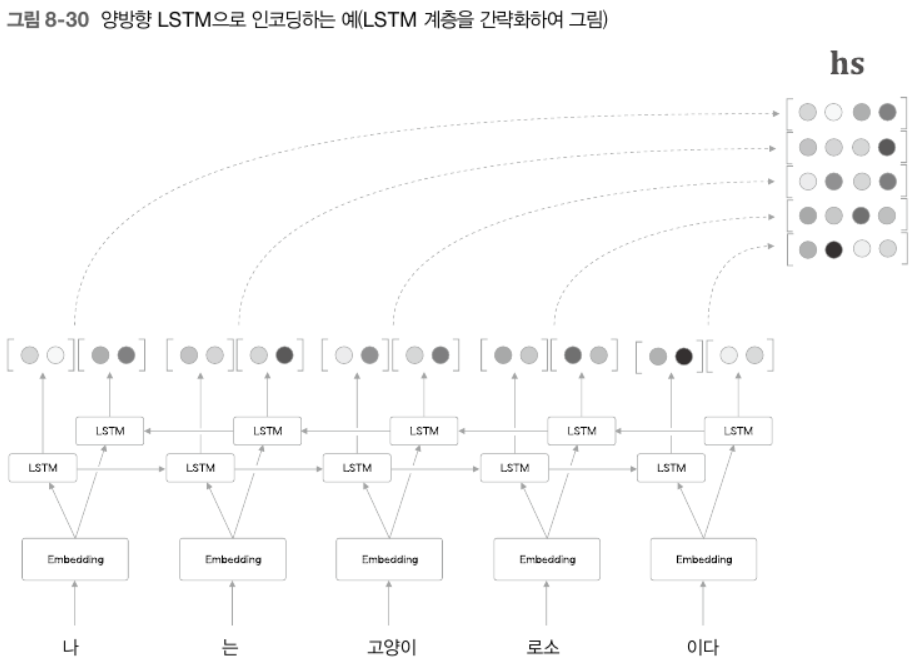

#### 8.4.2 Attention 계층 사용 방법

<img src=attachment:image.png width=500px></img>

Attention 계층의 출력 (맥락 벡터)이 다음 시각의 LSTM 계층에 입력되도록 연결하였습니다.

이렇게 구성하면 LSTM 계층이 맥락 벡터의 정보를 이용할 수 있습니다.
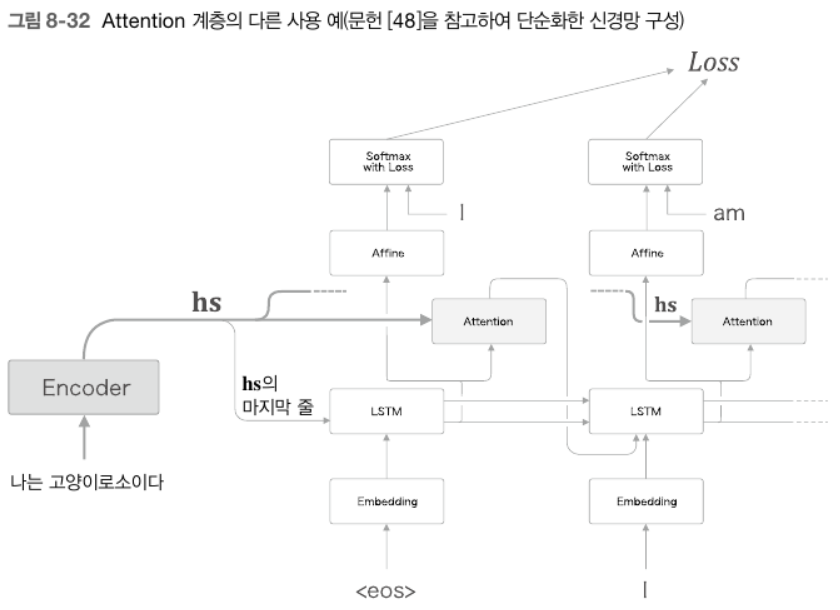

#### 8.4.3 seq2seq 심층화와 skip 연결

<img src=attachment:image.png width=500px></img>

RNN 계층(LSTM 계층)을 깊게 쌓아 seq2seq에 더 높은 표현력을 구현합니다.

단, 계층을 깊게 할 경우에는 일반화 성능을 떨어뜨리지 않도록 드롭아웃과 가중치 공유 등의 기술을 사용해야합니다.
<br><br>

<img src=attachment:image-2.png width=200px></img>
또 층을 깊게 할때 **skip 연결**, 다른말로 '잔차 연결' 혹은 '숏컷' 기법을 사용하기도 합니다.

계층을 건너뛰어 '선을 연결'하는 단순한 기법입니다. 

원소별 덧셈은 역전파 시 기울기를 '그대로 흘려'보내므로 층이 깊어져도 기울기가 소실(혹은 폭발)되지 않고 전파되어, 결과적으로 좋은 학습을 기대할 수 있습니다.
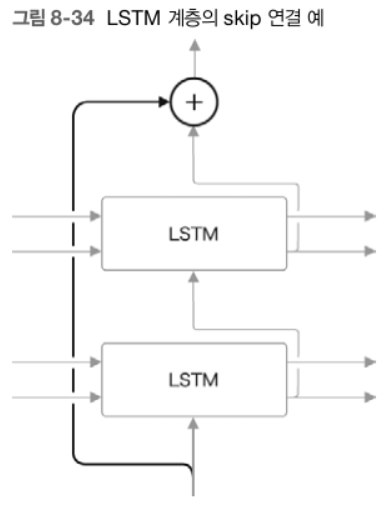
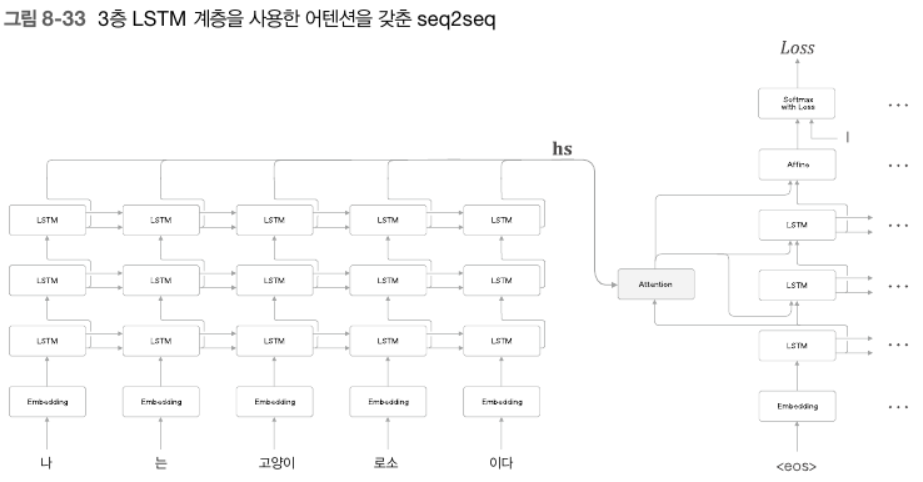

### 8.6 어텐션 응용

#### 8.5.1 구글 신경망 기계 번역(GNMT)

<img src=attachment:image.png width=500px></img>

번역 정확도를 높이기 위하여 LSTM 계층의 다층화, 양방향 LSTM, skip 연결 등을 볼 수 있습니다.

또한, 학습 시간을 단축하기 위해 다수의 GPU로 분산 학습을 수행하고 있습니다.
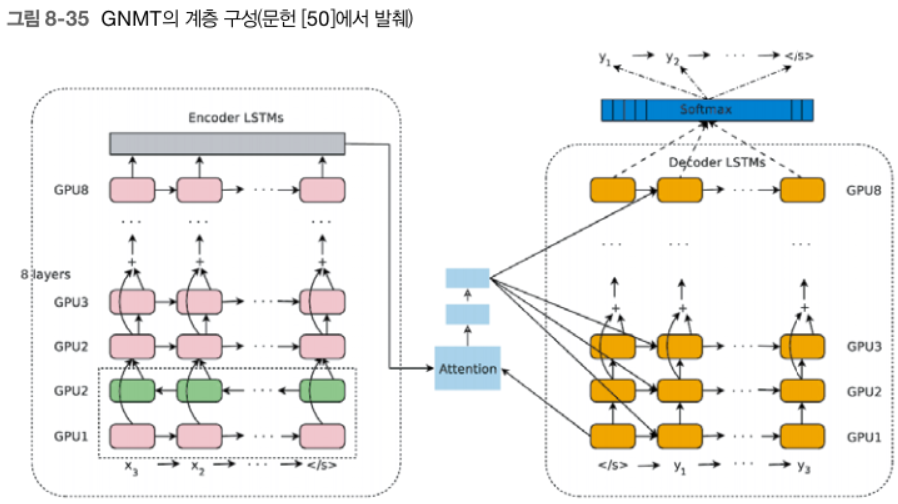

#### 8.5.2 트랜스포머

병렬처리가 불가능한 점 때문에, RNN을 없애는 연구로 **트랜스포머**<sup>Transformer</sup> 기법이 제안되었습니다.

<img src=attachment:image.png width=500px></img>

**셀프어텐션**<sup>Self-Attention</sup>이라는 기술을 이용하였는데, '하나의 시계열 데이터 내에서' 각 원소가 다른 원소들과 어떻게 관련되는지를 살펴보자는 취지입니다.

Feed Forward 계층은 피드포워드 신경망(시간 방향으로 독립적으로 처리하는 신경망)을 나타내고, Nx는 회색 배경으로 둘러쌓인 계층들을 N겹 쌓았다는 뜻입니다.
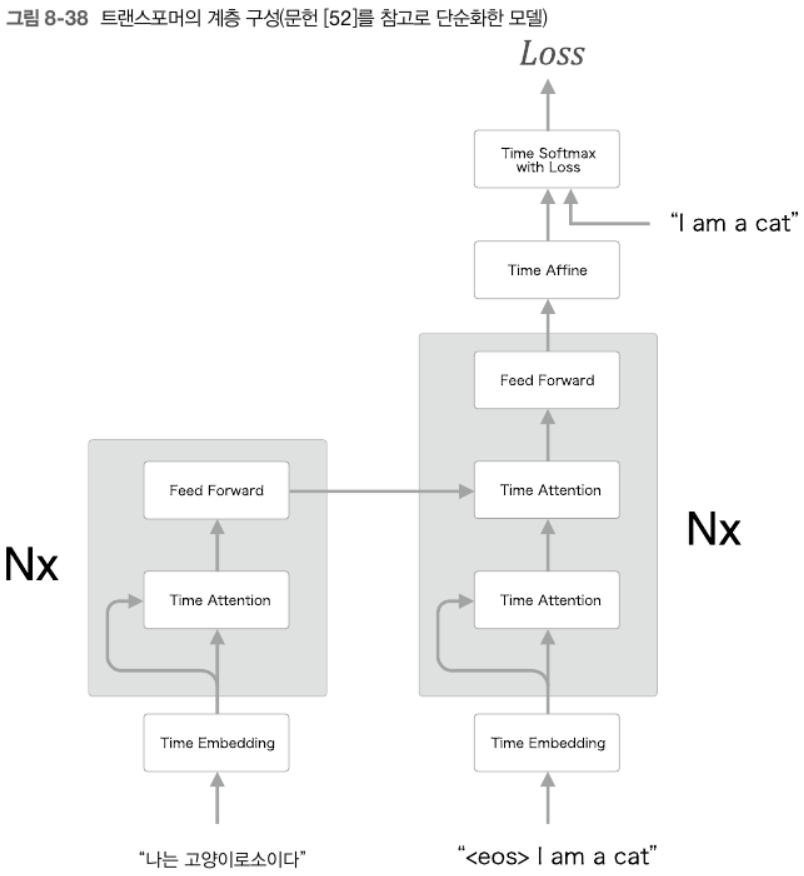

#### 8.5.3 뉴럴 튜링 머신(NTM)

NTM은 외부 메모리에 (컴퓨터처럼) 읽고 쓰기를 수행합니다.

<img src=attachment:image.png width=500px></img>

NTM은 컴퓨터의 메모리 조작을 모방하기 위해서 2개의 어텐션 '콘텐츠 기반 어텐션'과 '위치 기반 어텐션'을 이용합니다.

**콘텐츠 기반 어텐션**은 입력으로 주어진 어느 벡터(질의<sup>query</sup> 벡터)와 비슷한 벡터를 메모리로부터 찾아내는 용도로 이용됩니다.

**위치 기반 어텐션**은 이전 시각에서 주목한 메모리의 위치(=메모리의 각 위치에 대한 가중치)를 기준으로 그 전후로 이동(시프트)하는 용도로 사용됩니다.
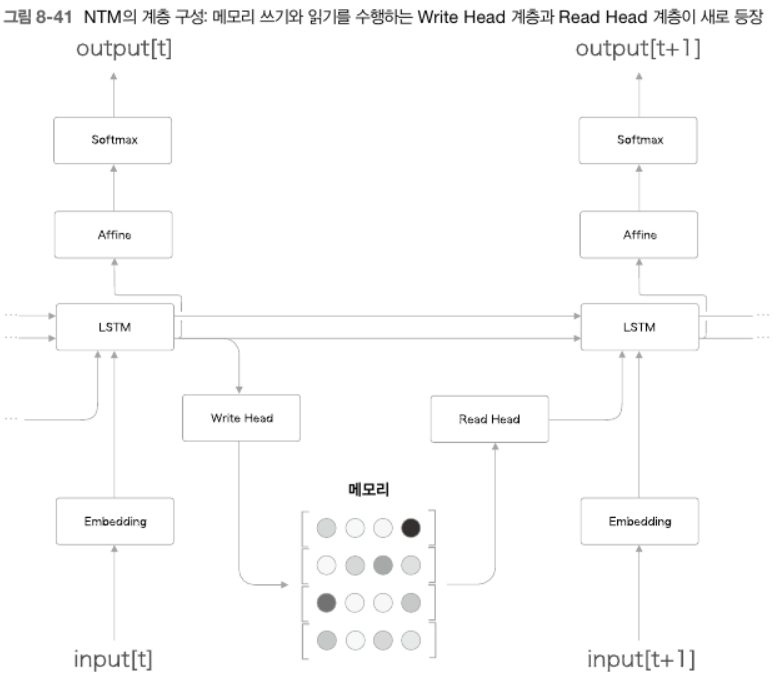